In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics

In [2]:
def mostrarHistograma(imagen):
    histograma = cv2.calcHist([imagen], [0], None, [256], [0,256])
    plt.figure(figsize = (10,7))
    plt.plot(np.arange(len(histograma[:,0])), histograma[:,0])

def muestra(imagen):
    cv2.imshow('',imagen)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [3]:
def mostrarHistograma(imagen, ax=None, etiqueta=None):
    imagen = np.uint8(imagen)  # Asegurarse de que la imagen esté en formato uint8
    histograma = cv2.calcHist([imagen], [0], None, [256], [0, 256])
    #histograma = histograma / histograma.max()  # Normalizar el histograma para que no se sobrepasen los límites
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    ax.plot(np.arange(256), histograma[:, 0],label=etiqueta)
    ax.set_xlim(0, 255)  # Asegurar que el eje X esté entre 0 y 255

In [4]:
def im_to_col(imagen, m, n):
    filas, columnas = imagen.shape
    a = m//2
    b = n//2
    imagen2 = np.zeros((m*n, filas*columnas))
    imagen = cv2.copyMakeBorder(imagen, a, a, b, b, cv2.BORDER_REPLICATE)
    aux = 0
    for i in range(a, filas+a):
        for j in range(b, columnas+b):
            imagen2[:, aux] = imagen[i-a:i+a+1, j-b:j+b+1].flatten()
            aux += 1
    return imagen2

In [5]:
def filtro_espacial(imagen, H):
    hfilas, hcolumnas = H.shape
    imagen2 = im_to_col(imagen,hfilas,hcolumnas)
    filas, columnas = imagen.shape
    for i in range(filas):
        for j in range(columnas):
            imagen[i,j] = np.sum(imagen2[:,i*columnas +j].reshape(H.shape) * H)
    return  imagen

In [6]:
def crea_imagen_final(imagen, labels, K):
    if len(imagen.shape) > 2:
        media_centros = np.zeros((K,3))
        for i in range(K):
            pix = imagen[labels == i]
            media_centros[i,:] = np.mean(pix,axis=0)
        nueva = media_centros[labels].reshape(imagen.shape)
        return nueva
    else:
        media_centros = np.zeros(K)
        for i in range(K):
            pix = imagen[labels == i]
            media_centros[i] = np.mean(pix,axis=0)
        nueva = media_centros[labels].reshape(imagen.shape)
        return nueva

In [7]:
def modificarImagen(imagen,n):
    imagen_modificada = cv2.resize(imagen, (n, n), interpolation=cv2.INTER_AREA)    
    return np.uint8(imagen_modificada)

In [8]:
def analisisImagen(imagen):
    media = np.mean(imagen)
    desviacion = np.std(imagen)
    max = np.max(imagen)
    min = np.min(imagen)

    analisis = {
        'media': media,
        'std': desviacion,
        'min': min,
        'max': max,
        'contraste': max-min
    }

    return analisis

In [9]:
from skimage.segmentation import slic

resolucion = 200

def prepro_rango_dinamico(nueva):
    #Ampliacion del rango dinamico
    nueva = np.float32(nueva)
    r1 = np.min(nueva)
    r2 = np.max(nueva)
    if r2-r1 < 100:
        nueva = 255 * (nueva - r1) / (r2 - r1)
    return np.uint8(nueva)

def prepro_ecualizacion_histograma(nueva):
    #Ecualizacion del histograma
    # num_pixels = nueva.size
    # hp = cv2.calcHist([nueva], [0], None, [256], [0,256])/num_pixels
    # hp = hp.cumsum()
    # nueva = hp[np.uint8(nueva)] * 255
    return cv2.equalizeHist(nueva)

def prepro_suavizado(nueva):
    #Suavizado
    # H = np.ones((5,5))/25
    # m,n = H.shape
    # imagen_aux = im_to_col(nueva,m,n)
    # filas, columnas = nueva.shape
    # H = H.reshape(1,-1)
    # nueva = H.dot(imagen_aux).reshape(-1,columnas)
    
    H = np.ones((5, 5), dtype=np.float32) / 25
    nueva = cv2.filter2D(nueva, -1, H)
    
    return np.uint8(nueva)

def prepro_gamma(imagen, gamma):
    tabla = np.array([((i / 255.0) ** gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(imagen, tabla)

def preprocesamiento(imagen): # todo junto

    analisis = analisisImagen(imagen)
    if analisis['std'] > 50:
        imagen = prepro_suavizado(imagen)
        
    analisis = analisisImagen(imagen)
    if analisis['contraste'] < 200:
        imagen = prepro_rango_dinamico(imagen)
        imagen = prepro_ecualizacion_histograma(imagen)

    analisis = analisisImagen(imagen)
    if analisis['media'] > 180:
        imagen = prepro_gamma(imagen, 2.0)
    elif analisis['media'] < 70:
        imagen = prepro_gamma(imagen, 0.5)

    return modificarImagen(imagen,resolucion)


# def preprocesamiento(imagen): # sin preprocesamiento
#     return imagen

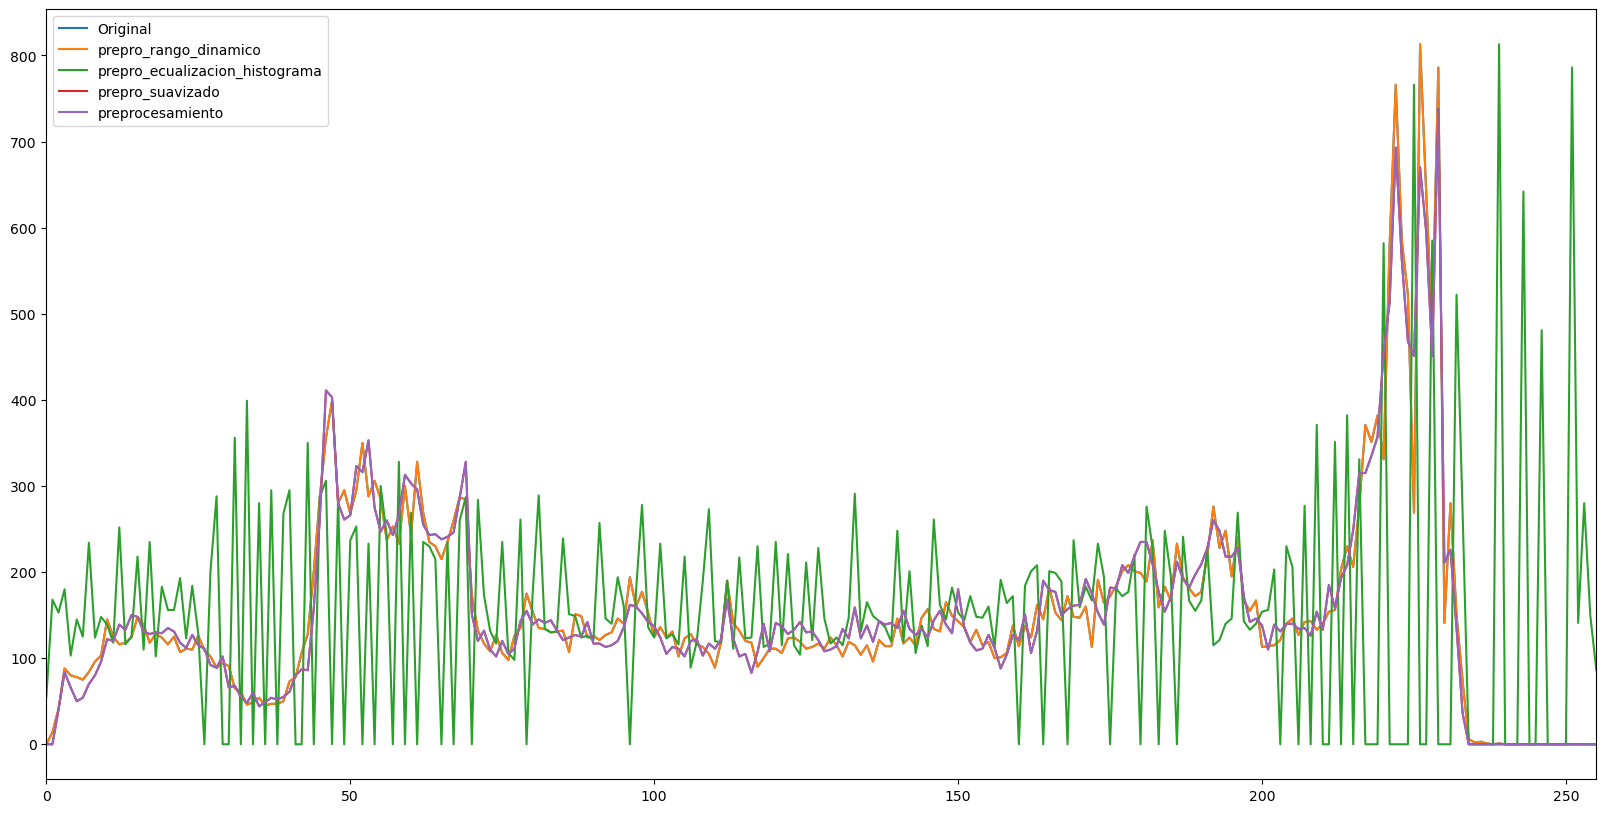

In [10]:
# Cargar la imagen
imagen = cv2.imread('dataset/cat_dog_100/train/cat/cat.0.jpg',0)

# Listado de técnicas de preprocesamiento
tecnicas_pre = [prepro_rango_dinamico,prepro_ecualizacion_histograma,prepro_suavizado,preprocesamiento] #,prepro_super_pixeles,prepro_ecualizacion_histograma,prepro_eliminar_fondo

# Crear la figura para los histogramas
fig, ax = plt.subplots(figsize=(20, 10))

# Mostrar histograma de la imagen original
mostrarHistograma(modificarImagen(imagen, resolucion), ax=ax, etiqueta="Original")
#cv2.imshow('Original', modificarImagen(imagen, resolucion))

# Aplicar las técnicas de preprocesamiento y mostrar los resultados
for i,tecnica in enumerate(tecnicas_pre):
    imagen2 = tecnica(modificarImagen(imagen,resolucion))
    mostrarHistograma(imagen2, ax=ax, etiqueta=tecnica.__name__)
    #cv2.imshow(tecnica.__name__, imagen2)

ax.legend()
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [11]:
muestra(preprocesamiento(imagen))

In [12]:
def gradiente(imagen):

    imagen_x = cv2.Sobel(imagen, cv2.CV_32F,1,0,ksize = 1)
    imagen_y = cv2.Sobel(imagen, cv2.CV_32F,0,1,ksize = 1)

    E = np.sqrt(np.power(imagen_x, 2) + np.power(imagen_y, 2))
    Phi = np.arctan2(imagen_y, imagen_x)
    Phi = np.rad2deg(Phi)

    return np.uint8(E), np.uint8(Phi)

In [13]:
def histogramasXceldas(num, E, phi):
    filas, columnas = imagen.shape
    histogramas = []
    for i in range(0, filas, num):
        for j in range(0, filas, num):
            celdaMag = E[i:i+num,j:j+num].flatten()
            celdaOri = phi[i:i+num,j:j+num].flatten()
            h = np.zeros(9)
            indices = celdaOri//(360//9)
            
            h = np.bincount(indices, weights=celdaMag, minlength=9)
            
            h = h/(np.sqrt(np.sum(h ** 2))+1e-6)
            histogramas.append(h)
    return histogramas
            

In [74]:
def extraccionCaracteristicas(imagen, num):
    imagen = np.float32(imagen)
    E, phi = gradiente(imagen)
    caracteristicas = np.concatenate(histogramasXceldas(num, E, phi))
    return caracteristicas

def extraccionCaracteristicasPuntos(imagen,num):
    mask = puntosSingulares(imagen)
    imagen = np.float32(imagen)
    E, phi = gradiente(imagen)
    E = E * mask  
    phi = phi * mask 
    caracteristicas = np.concatenate(histogramasXceldas(num, E, phi))

    return caracteristicas

def extraccionCaracteristicasPuntosEspacial(imagen,num):
    mask = puntosSingulares(imagen)
    coordenadas = np.argwhere(mask == 1)

    h, w = imagen.shape
    hist = np.zeros((num, num))

    for y, x in coordenadas:

        grid_y, grid_x = y * num // h, x * num // w

        hist[grid_y, grid_x] += 1
    
    feature_vector = hist.flatten()
    feature_vector = feature_vector / np.linalg.norm(feature_vector)

    return feature_vector

def puntosSingulares(imagen):
    imagen = np.float32(imagen)
    dst = cv2.cornerHarris(imagen,2,3,0.04)
    dst = cv2.dilate(dst,None)
    mask = (dst>0.01*dst.max())
 
    return mask

In [22]:
imagen = cv2.imread('dataset/cat_dog_100/train/cat/cat.0.jpg',0)

img = puntosSingulares(imagen)
cv2.imshow('dst',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

497094.6


In [87]:
def cargarImagenes(pathfile):
    X, y, imagenes = [], [], []
    clases = ['cat','dog']
    
    for clase in clases:
        ruta = os.path.join(pathfile, clase)
        archivos = glob.glob(os.path.join(ruta, "*.jpg"))
        for archivo in archivos:
            imagen = cv2.imread(archivo, 0) 
            imagenes.append(imagen)
            imagen = preprocesamiento(imagen)
            caracteristicas = extraccionCaracteristicasPuntosEspacial(imagen, 8)
            # caracteristicas = extraccionCaracteristicas(imagen, 16)
            X.append(caracteristicas)

            if clase == 'cat':
                y.append(0)
            else:
                y.append(1)
                
    return imagenes, np.array(X), np.array(y)

In [79]:
def entrenamiento():
    imagenes, X_train, y_train = cargarImagenes('dataset/cat_dog_100/train') 
    
    print("empieza el entrenamiento del clasificador")

    # clasificador = MLPClassifier(random_state=42, max_iter=300, solver = 'adam', activation = 'relu')
    parametros = {
        'svc__C': [0.1, 1, 10],
        'svc__kernel': ['linear', 'rbf']
    }
    
    # clasificador = GridSearchCV(estimator=SVC(), param_grid=parametros, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
    
    clasificador = make_pipeline(StandardScaler(), SVC())
    
    modelo = GridSearchCV(estimator = clasificador, param_grid=parametros, cv=7, scoring='accuracy')
  
    modelo.fit(X_train, y_train)

    # print("Mejores parámetros:", modelo.best_params_)
    # print(f"Mejor puntuación: {clasificador.best_score_}")

    return modelo

In [31]:
def evaluacion(modelo):
    imagenes, X_test, y_test = cargarImagenes('dataset/cat_dog_100/test')
    
    y_pred = modelo.predict(X_test)

    acc = np.round(metrics.accuracy_score(y_pred,y_test)*100,2)

    

    return acc, imagenes, y_pred

In [88]:
print("empieza entrenamiento")
modelo = entrenamiento()
print("empieza evaluacion")
acc, imagenes, predicciones = evaluacion(modelo)
print('El porcentaje de acierto del modelo es del {}%'.format(acc))

# for i,imagen in enumerate(imagenes):
#     if predicciones[i] == 0:
#         label = 'Clasificada como gato'
#     else:
#         label = 'Clasificada como perro'
        
#     cv2.imshow(label, imagen)
#     cv2.waitKey(0)

# cv2.destroyAllWindows()

empieza entrenamiento
empieza el entrenamiento del clasificador
empieza evaluacion
El porcentaje de acierto del modelo es del 85.0%
